# **Complément de cours**

Manifestement une compétence clé attendue dans le cadre de ce projet P4.

Deux librairies proposées, **Lime** et **Shap**, des articles et des tutos.

Les sources externes :
1. https://coderzcolumn.com/tutorials/machine-learning/2. shap-explain-machine-learning-model-predictions-using-game-theoretic-approach
3. https://colab.research.google.com/drive/1pjPzsw_uZew-Zcz646JTkRDhF2GkPk0N
4. How to Calculate Feature Importance With Python
5. Introduction à l'interprétation de modèles de Machine Learning - OCTO Talks !
https://towardsdatascience.com/interpretability-in-machine-learning-70c30694a05f



[Introduction à l’interprétation de modèles de Machine Learning](https://blog.octo.com/introduction-a-linterpretation-de-modeles-de-machine-learning/)

Octos Talk - Posté le 10/06/2020 par Rym Laabiyad

ML : compromis entre performance et interprétabilité :
* modèles linéaires et arbres de décisions interprétables mais moins performants.
* modèles boîte noire comme XGBoost ou réseaux de neurones plus performants mais non (directement) interprétables.

Méthodes d'interprétation agnostiques (indépendantes du modèle).

Interprétations globales (du modèle) vs. locales (d'instances).

Datasets des exemples :

* Données tabulaires pour régression (Boston) : https://scikit-learn.org/stable/datasets/index.html#boston-dataset
* Pour classification (Iris) : https://scikit-learn.org/stable/datasets/index.html#iris-dataset
* Images grayscale : https://scikit-learn.org/stable/datasets/index.html#digits-dataset
* Images RGB : https://www.tensorflow.org/datasets/catalog/cats_vs_dogs


4 méthodes / librairies étudiées :
* LIME
* Feature permutation
* SHAP
* Exemples contrefactuels
* Ancres


<mark>Reprendre le tableau comparatif</mark>


## 1. Substitut global



## 2. LIME (*Local Interpretable Model-agnostic Explanations*)

* ...

## 3. Permutation Feature Importance

## 4. SHAP (*SHapley Additive exPlanations*)

## 5. Exemples / explications contrefactuelles



## 6. Ancres (Anchors, ou Scoped rules)

Wikipedia ?

Principe :
* Interprétation en termes de règles : $x_1 = v_1 .. x_2 = v_2 \Rightarrow pred_1$
*


## Conclusion

Nietszche : *Il n'y a pas de faits, il n'y a que des interprétations.*

Enjeu : adoption

L'humain a besoin de comprendre.

Si un modèle fonctionne mais reste une boîte noire, cela freine son adoption. Le blocage peut aussi être légal (ou éthique).

Invitation à approfondir avec le livre de Christopher Molnar, Interpretable Machine Learning.


# Lime vs Shap - Exemple de code (Notebook)

**Source** : [Interpretability Revisited: LIME and SHAP in prose and code.ipynb](https://colab.research.google.com/drive/1pjPzsw_uZew-Zcz646JTkRDhF2GkPk0N)

## Interprétabilité : LIME et SHAP en prose et en code

Victor Dibia. Ingénieur de recherche, Cloudera Fast Forward Labs. 8 mai 2020

Chez [Cloudera Fast Forward](https://www.cloudera.com/products/fast-forward-labs-research.html), nous considérons l'interprétabilité des modèles comme une étape importante dans le flux de travail de la science des données. Pouvoir expliquer le fonctionnement d'un modèle sert à plusieurs fins, notamment renforcer la confiance dans la sortie du modèle, satisfaire aux exigences réglementaires, déboguer le modèle et vérifier la sécurité du modèle, entre autres. Nous avons rédigé un rapport de recherche (accessible gratuitement ici) qui aborde ce sujet en détail. Dans cet article, nous revisitons deux algorithmes standard de l'industrie pour l'interprétabilité - LIME et SHAP. Nous discutons du fonctionnement de ces deux algorithmes et montrons quelques exemples de code sur la façon de les implémenter en python. À la fin de cet article, vous devriez être familiarisé avec :
* Un aperçu de l'interprétabilité du modèle
* Interprétation des modèles de boîte blanche, tels que la régression linéaire/logistique (à l'aide de coefficients de modèle) et les modèles d'arbres (à l'aide des scores d'importance des caractéristiques)
* Interpréter les modèles de boîtes noires avec LIME et SHAP (KernelExplainer, TreeExplainer) et comment les implémenter en python
* Bonnes pratiques pour "déboguer" les explications LIME et SHAP
* Limitations de LIME/SHAP (alias, quand choisir LIME plutôt que SHAP)

In [2]:
%pip install -q shap umap-learn lime 
# dl %curl -L -O https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv
%pip install xgboost

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [1]:
#@title

import os
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.metrics import classification_report


import shap
from lime.lime_tabular import LimeTabularExplainer
import xgboost
import seaborn as sns; 
import umap 

 
import matplotlib.pyplot as plt
import matplotlib 

idcol = 'customerID'
labelcol = 'Churn'
cols = (('gender', True),
        ('SeniorCitizen', True),
        ('Partner', True),
        ('Dependents', True),
        ('tenure', False),
        ('PhoneService', True),
        ('MultipleLines', True),
        ('InternetService', True),
        ('OnlineSecurity', True),
        ('OnlineBackup', True),
        ('DeviceProtection', True),
        ('TechSupport', True),
        ('StreamingTV', True),
        ('StreamingMovies', True),
        ('Contract', True),
        ('PaperlessBilling', True),
        ('PaymentMethod', True),
        ('MonthlyCharges', False),
        ('TotalCharges', False))

def drop_non_features(df, cols):
    return df[[c for c, _ in cols]]

def drop_missing(df):
    '''Remove rows with missing values'''
    return df.replace(r'^\s$', np.nan, regex=True).dropna()


def clean(df):
    # Make target variable a true boolean column
    # Drop unpredictive column
    df.drop(['customerID'], axis=1)

def categorize(df, cols):
    catcols = (c for c, iscat in cols if iscat)
    for col in catcols:
        df[col] = pd.Categorical(df[col])
    return df

def booleanize_senior_citizen(df):
    '''Make SeniorCitizen 'Yes'/'No' like other columns in this dataset.'''
    return df.replace({'SeniorCitizen': {1: 'Yes', 0: 'No'}})

def splitdf(df, label):
    return df.drop(label, axis=1), df[label]

def load_dataset():
    '''Return IBM customers and labels.'''
    df = pd.read_csv("Telco-Customer-Churn.csv")
    df = drop_missing(df).reset_index()
    df.index.name = 'id'
    features, labels =  splitdf(df, labelcol)
    features = booleanize_senior_citizen(features)
    features = drop_non_features(features, cols)
    features = categorize(features, cols)
    labels = (labels == 'Yes')
    return features, labels
  
def setup_plot():
  plt.rcParams["axes.grid.axis"] ="y"
  plt.rcParams["axes.grid"] = True
  plt.rcParams["legend.fontsize"] = 14
  plt.rc('grid', linestyle="dashed", color='lightgrey', linewidth=1)
  plt.rcParams["xtick.labelsize"] = 15
  plt.rcParams["ytick.labelsize"]  = 15 

L'ensemble de données (baratte client)

Pour cet article, nous illustrons notre discussion à l'aide d'un ensemble de données public de 7 043 clients du câble, dont environ 25 % ont abandonné. Il existe 20 caractéristiques pour chaque client, qui sont un mélange d'attributs intrinsèques de la personne ou du foyer (sexe, taille de la famille, etc.) et des quantités qui décrivent leur service ou leur activité (mode de paiement, charge mensuelle, etc.).

Le jeu de données contient à la fois des entités continues et catégorielles.

Selon le type de modèle, nous pouvons prendre différentes décisions sur la manière dont les champs catégoriels sont représentés. Par exemple, les modèles arborescents peuvent être entraînés directement avec des caractéristiques catégorielles (étiquette codée), tandis que d'autres modèles (par exemple, la régression logistique, les réseaux de neurones) fonctionnent mieux avec une variable catégorique encodée à chaud.

In [2]:
data, labels = load_dataset()  

# Get categorical column indexes
cat_columns_ix_ = {c: i for i, c in enumerate(data.columns)
                                if pd.api.types.is_categorical_dtype(data[c])}
# categorical column names
cat_columns  = [c for c in (data.columns) if pd.api.types.is_categorical_dtype(data[c])]
# num_cat_columns  = [c for c in (data.columns) if pd.api.types.is_categorical_dtype(data[c])]

# Make copies of data with various representations for categorical features. 
data_numeric = data.copy() # categorical fields are label encoded but numerical
data_categorical = data.copy() # categorical fields are label encoded, numeric but categorical type
data_ohe =  pd.get_dummies(data,columns=cat_columns, sparse=False) # categorical fields are one hot encoded

# Convert categorical columns to numeric encoded labels
for col in cat_columns:
  data_numeric[col] = (LabelEncoder().fit_transform(data_numeric[col]))
  data_categorical[col] = data_numeric[col].astype("category")  


# Set data used for explorations
# Hint .. Change this to other version of the data and observe changes in results.
current_data = data_categorical  
print("Available features: \n", list(data_categorical.columns)) 
print("Label Balance - [No Churn, Churn] : ", list(labels.value_counts()))

Available features: 
 ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges']
Label Balance - [No Churn, Churn] :  [5163, 1869]


## Que sont les modèles généraux dans l'ensemble de données ?

Il est souvent utile d'explorer visuellement la relation entre les entités en entrée et les étiquettes en sortie. Cela donne une idée de la complexité du problème et peut éclairer le choix du modèle à explorer.
* Tracés de corrélation

Nous pouvons explorer les [visualisations par paires](https://seaborn.pydata.org/generated/seaborn.pairplot.html) de variables continues dans l'ensemble de données. Pour réduire la complexité de calcul de ces tracés, certaines caractéristiques sont regroupées et remplacées par leur valeur moyenne. Un examen rapide des résultats ici suggère que les clients qui ont refusé semblent avoir des frais mensuels plus élevés.
* Réduction de la dimensionnalité

Dans un premier temps, nous pouvons appliquer des techniques de réduction de dimensionnalité linéaires ([ACP](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)) et non linéaires ([UMAP](https://umap-learn.readthedocs.io/en/latest/)) aux entités de l'ensemble de données.

Les résultats de l'[ACP](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) et de l'[UMAP](https://umap-learn.readthedocs.io/en/latest/) sont présentés ci-dessous. Les deux méthodes sont utilisées pour réduire la dimension de l'entité en entrée à deux dimensions et visualisées sous forme de nuage de points. Notez que les résultats de l'ACP ne montrent aucune séparation claire entre les points de données des clients désabonnés et non désabonnés (pour la quantité de variance expliquée). Cela suggère que les modèles capables de modéliser des modèles non linéaires sont plus adaptés à cette tâche.


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<Figure size 1440x720 with 0 Axes>

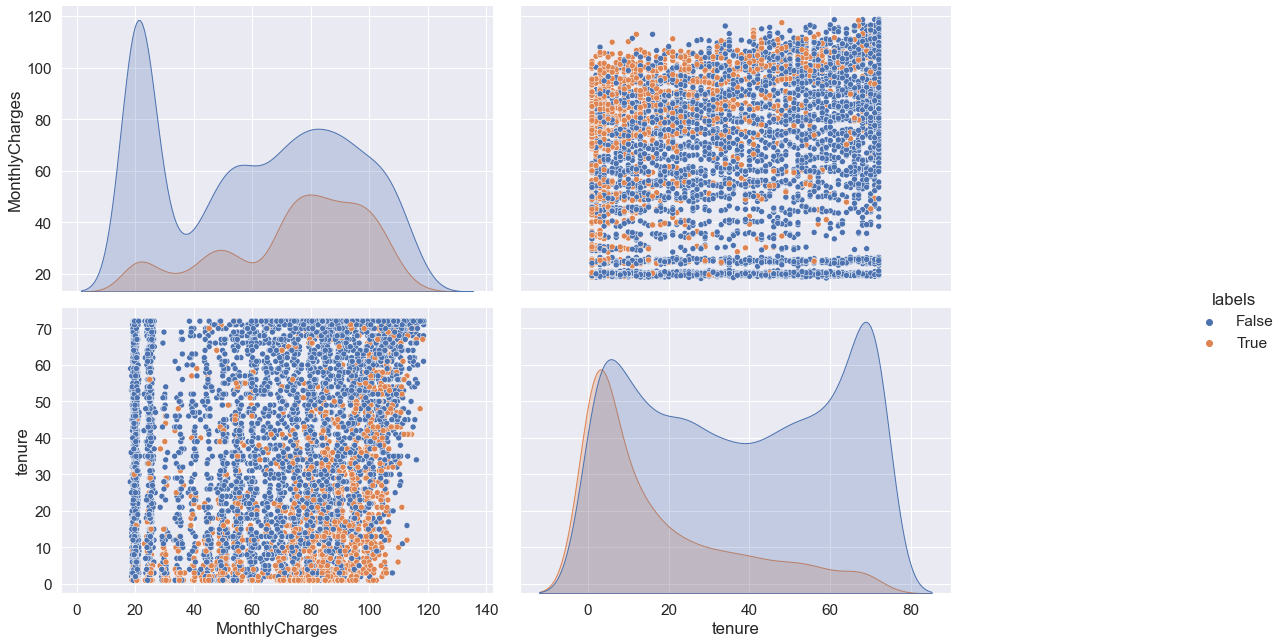

In [3]:
#@title
# Seaborn visualization library
import seaborn as sns
fig = plt.figure(figsize=(20,10))

# Create the df for  pairplot
sns_df = current_data[["MonthlyCharges", "tenure" ]]
sns_df["labels"] = (labels.values )


# Bin the totalCharges column into 5 bins. Replace by mean of bin interval
n_bins = 5
sns.set(font_scale = 1.4)
total_charges = current_data["TotalCharges"].astype(float)
lower, higher = int(total_charges.min()), int(total_charges.max())
edges = range(lower, higher, int((higher - lower)/n_bins))  
lbs = [ (edges[i] + edges[i+1])/2 for i in range(len(edges)-1)]  
sns_df["totalCharges"] = pd.cut(total_charges, bins=n_bins, labels=lbs, include_lowest=True)

# Plot data usig pai
ax = sns.pairplot(sns_df,  diag_kind = 'kde', hue="labels" ) 
ax.fig.set_size_inches(20,10)

Explained variation per principal component:  0.9999818703929234 (7032, 2)
 > PCA Complete =========== (7032, 19)
Explained variation per principal component:  0.3443562376478491 (7032, 2)
 > PCA Complete =========== (7032, 19)


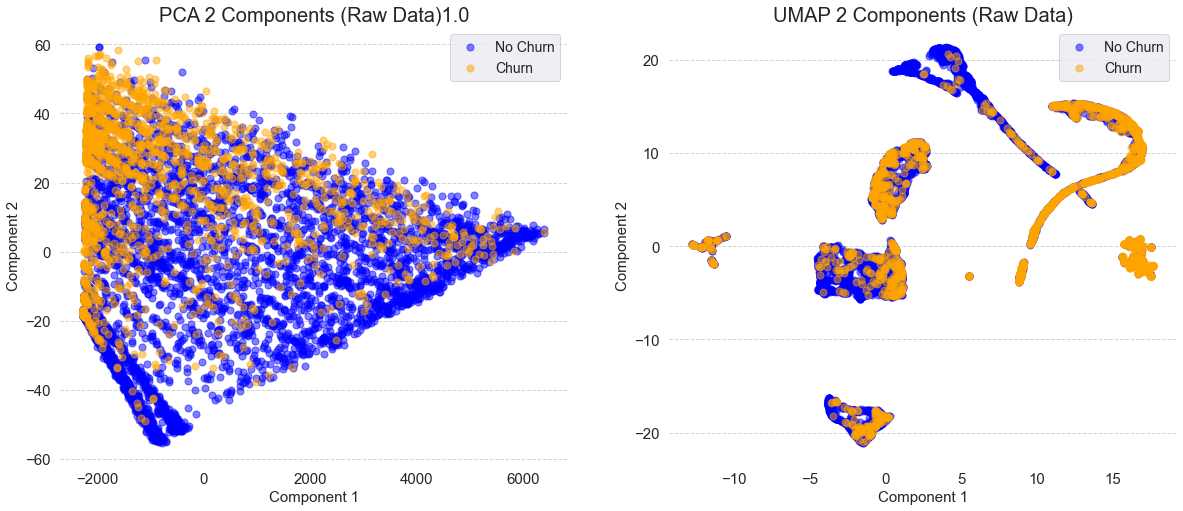

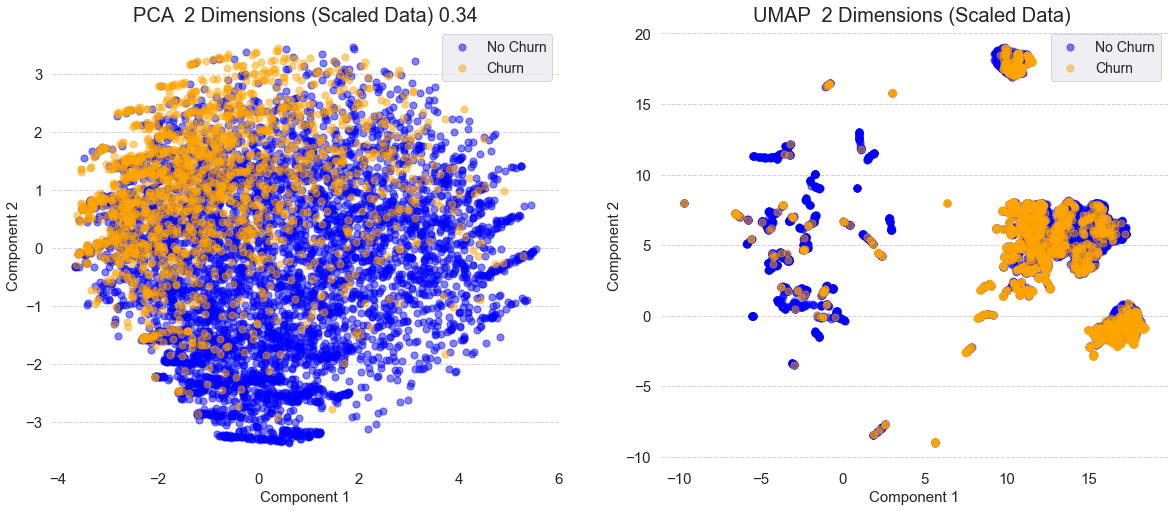

In [5]:
#@title
from sklearn.decomposition import PCA

def reduce_dimensions_umap(df):
  reducer = umap.UMAP(metric="cosine")
  embedding = reducer.fit_transform(df)
  return embedding
 
# reduce dimensions via pca
def reduce_dimensions_pca(df, num_features):
    num_features = min(num_features, df.shape[1])
    pca = PCA(n_components=num_features)
    pca = pca.fit(df.values)
    pca_result = pca.transform(df.values)
    print("Explained variation per principal component: ",
          np.sum(pca.explained_variance_ratio_), pca_result.shape)
    print(" > PCA Complete ===========", df.shape)
    return pca, pca_result

def visualize_dims(fig, fig_index, pca_vals, labels, title):
  col_names = [ "pc" +str(e) for e in range(1, pca_vals.shape[1] +1 )] 
  pdpca = pd.DataFrame(pca_vals, columns=col_names)
  pdpca["label"]  = labels

  # Plot PCA values
 
  ax = fig.add_subplot(1,2, fig_index) 
  ax.set_xlabel('Component 1', fontsize = 15)
  ax.set_ylabel('Component 2', fontsize = 15)
  ax.set_title(title, fontsize = 20)
  targets = list(labels.unique())
  colors = ['blue', 'orange']
  for target, color in zip(targets,colors):
      indicesToKeep = pdpca['label'] == target 
      ax.scatter(pdpca.loc[indicesToKeep, 'pc1']
                , pdpca.loc[indicesToKeep, 'pc2']
                , c = color
                 , alpha = 0.5
                , s = 50)
  ax.legend(["No Churn", "Churn"])  

scaler = StandardScaler()
scaled_current_data = pd.DataFrame(scaler.fit_transform(current_data))
# compute pca and umap projections
def plot_dim_reduction(data, scale_status):
  num_components = 2 
  # visualize projections
  setup_plot()
  fig = plt.figure(figsize = (20,8))
  pca, pca_vals = reduce_dimensions_pca(data, num_components)
  visualize_dims(fig, 1,pca_vals, labels, "PCA " + scale_status +  str(round(np.sum(pca.explained_variance_ratio_),2)) ) 
  plt.box(False)

  umap_vals = reduce_dimensions_umap(data)
  visualize_dims(fig, 2, umap_vals, labels, "UMAP " + scale_status)
  plt.box(False) 

# Note the PCA visualization only is useful for
# inferring properties in the data if 2 component pca 
# explains a large amount of variance.
plot_dim_reduction(current_data, "2 Components (Raw Data)"  )
plot_dim_reduction(scaled_current_data,  " 2 Dimensions (Scaled Data) " )


## Entraînement de modèle

Nous pouvons entraîner un ensemble de modèles sur l'ensemble de données de désabonnement et comparer leurs performances. Pour simplifier ce processus, nous utiliserons la bibliothèque sklearn et utiliserons l'API model.fit() pour former le modèle tout en enregistrant la précision de l'entraînement et du test. Les modèles suivants sont entraînés :
* Bayes naïf
* Régression logistique
* Arbre de décision
* Forêt aléatoire
* Arbre boosté en dégradé
* Perceptron multicouche

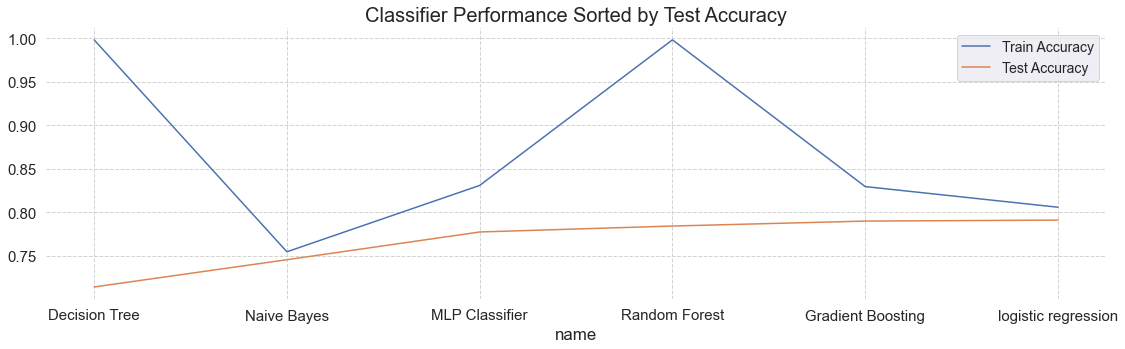

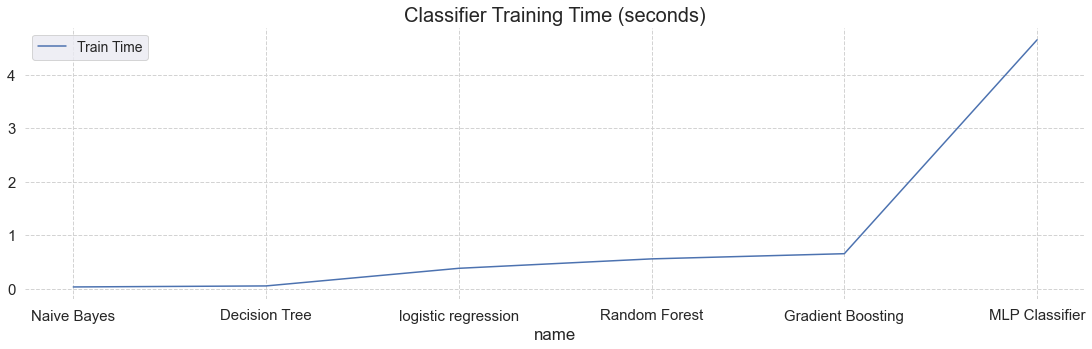

In [6]:
#@title
import time
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegressionCV

trained_models = [] #  keep track of all details for models we train
def train_model(model, data, labels): 
  X = data
  y = labels.values
  X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

  pipe = Pipeline([('scaler', StandardScaler()),('clf', model["clf"])])
  start_time = time.time()
  pipe.fit(X_train, y_train)
  train_time = time.time() - start_time

  train_accuracy =  pipe.score(X_train, y_train)
  test_accuracy = pipe.score(X_test, y_test) 
  model_details = {"name": model["name"], "train_accuracy":train_accuracy, "test_accuracy":test_accuracy, "train_time": train_time, "model": pipe}
  return model_details

models = [
          {"name": "Naive Bayes", "clf": GaussianNB()},
          {"name": "logistic regression", "clf": LogisticRegressionCV()}, 
          {"name": "Decision Tree", "clf": DecisionTreeClassifier()},
          {"name": "Random Forest", "clf": RandomForestClassifier(n_estimators=100)},
          {"name": "Gradient Boosting", "clf": GradientBoostingClassifier(n_estimators=100)}, 
          {"name": "MLP Classifier", "clf": MLPClassifier(solver='adam', alpha=1e-1, hidden_layer_sizes=(10,10,5,2), max_iter=500, random_state=42)}]

for model in models:
  model_details = train_model(model, current_data, labels) 
  trained_models.append(model_details)


# visualize accuracy and run time
setup_plot()
model_df = pd.DataFrame(trained_models)
model_df.sort_values("test_accuracy", inplace=True) 
ax = model_df[["train_accuracy","test_accuracy", "name"]].plot(kind="line", x="name", figsize=(19,5), title="Classifier Performance Sorted by Test Accuracy")
ax.legend(["Train Accuracy", "Test Accuracy"])
for p in ax.patches:
    ax.annotate( str( round(p.get_height(),3) ), (p.get_x() * 1.005, p.get_height() * 1.005))

ax.title.set_size(20)
plt.box(False)

model_df.sort_values("train_time", inplace=True)
ax= model_df[["train_time","name"]].plot(kind="line", x="name", figsize=(19,5), grid=True, title="Classifier Training Time (seconds)")
ax.title.set_size(20)
ax.legend(["Train Time"])
plt.box(False)

La figure montre a) Performances de 6 classifieurs. Bien que les modèles d'arbre de décision (non ajusté) et de forêt aléatoire aient une grande précision d'entraînement, ils ne fonctionnent pas aussi bien sur l'ensemble de test, ce qui indique un surapprentissage pour ce problème. L'arborescence boostée par gradient et la régression logistique ont un bon équilibre entre la précision de l'entraînement et du test pour cet ensemble de données. b) Temps d'entraînement.

## Expliquer les modèles

À ce stade, nous avons entraîné quelques modèles et nous pouvons les utiliser pour obtenir des prédictions. Compte tenu des données pour chaque client du câble, nous pouvons prédire la probabilité qu'ils se désabonneront. Cependant, ce qui n'est pas très clair, c'est comment chacune de ces caractéristiques contribue à la probabilité de désabonnement prévue. Nous pouvons penser à ces explications en termes globaux (c'est-à-dire, comment chaque caractéristique impacte-t-elle les résultats sur la moyenne pour l'ensemble de la fiche technique ?) ou en termes locaux (c'est-à-dire, comment chaque caractéristique impacte-t-elle les prévisions pour un client donné ?). Certains modèles ont des propriétés intégrées qui fournissent ce genre d'explications. Ceux-ci sont généralement appelés modèles de boîte blanche et les exemples incluent la régression linéaire (coefficients de modèle), la régression logistique (coefficients de modèle) et les arbres de décision (importance des caractéristiques). En raison de leur complexité, d'autres modèles - tels que les forêts aléatoires, les arbres boostés par gradient, les SVM, les réseaux de neurones, etc. - n'ont pas de méthodes simples pour expliquer leurs prédictions. Pour ces modèles (également appelés modèles de boîte noire), des approches telles que LIME et SHAP peuvent être appliquées.

### Explication globale - Coefficients de régression logistique

Pour les modèles tels que la régression linéaire et logistique, nous pouvons examiner les coefficients du modèle pour déduire l'importance des caractéristiques (notez que les coefficients doivent être interprétés avec soin pour chaque type de modèle). Cela nous donne une idée de la façon dont une augmentation/modification de chaque fonctionnalité pourrait entraîner une modification des cotes de journal que le client va perdre. Nous pouvons également obtenir une compréhension générale de l'importance d'une caractéristique pour l'ensemble de données.

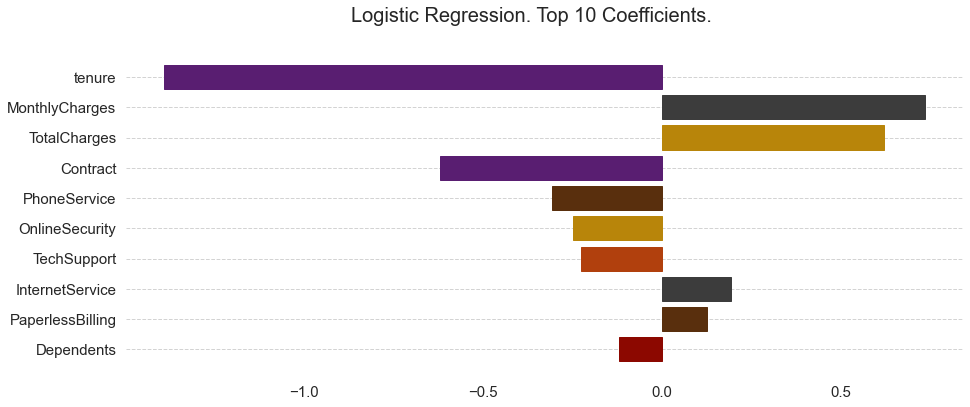

In [7]:
plt.figure(figsize=(15, 6))
X_train, X_test, y_train, y_test = train_test_split(current_data, labels.values, random_state=42)
logistic_reg_coeff = trained_models[1]["model"]["clf"].coef_
color_list =  sns.color_palette("dark", len(current_data.columns)) 
top_x = 10
logistic_reg_coeff = trained_models[1]["model"]["clf"].coef_[0]
idx = np.argsort(np.abs(logistic_reg_coeff))[::-1] 
lreg_ax = plt.barh(current_data.columns[idx[:top_x]][::-1], logistic_reg_coeff[idx[:top_x]][::-1])
for i, bar in enumerate(lreg_ax):
  bar.set_color(color_list[idx[:top_x][::-1][i]])
  plt.box(False) 
lr_title = plt.suptitle("Logistic Regression. Top " + str(top_x) + " Coefficients.", fontsize=20, fontweight="normal")

## Explications via les scores d'importance des fonctionnalités [modèles basés sur des arbres]

Les modèles arborescents ont des propriétés qui nous permettent de déduire l'importance d'une caractéristique. Pour chaque arbre de décision, nous pouvons calculer la diminution moyenne de l'impureté pour chaque caractéristique - c'est-à-dire l'impact de la caractéristique sur la réduction de l'incertitude (classifieurs) ou de la variance (régresseurs) de la prédiction de l'arbre de décision. Cette valeur est également connue sous le nom de score d'importance de Gini. Pour chaque modèle basé sur un arbre dans notre liste de modèles entraînés, nous pouvons tirer parti de l'implémentation de sklearn feature_importance et visualiser l'importance moyenne de chaque variable.

Text(0.5, 0.98, 'Feature Importance for Tree Models. Top 10 Features.')

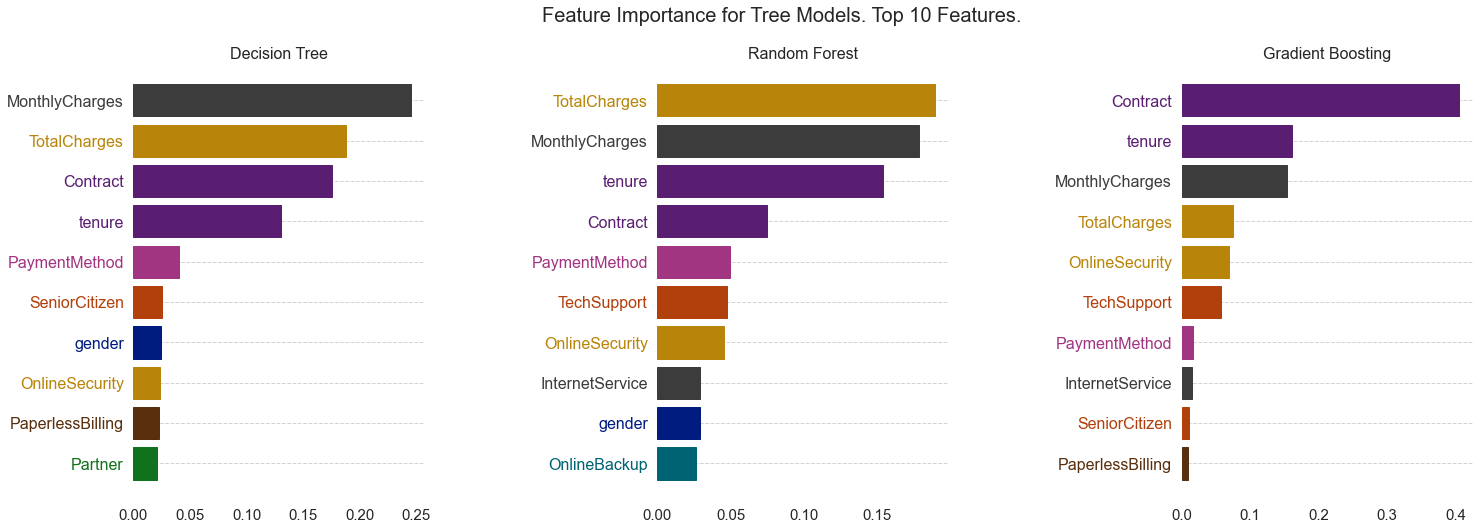

In [8]:
#@title
# Create array of tree based models and plot feature importance scores
tree_models = []
setup_plot()
color_list =  sns.color_palette("dark", len(current_data.columns)) 
top_x = 10 # number of x most important features to show
for model in trained_models:
  if hasattr(model["model"]["clf"], 'feature_importances_'): 
    tree_models.append({"name":model["name"], "fi": model["model"]["clf"].feature_importances_}) 
  

fig, axs = plt.subplots(1,3, figsize=(24, 8), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.5, wspace=0.8)
axs = axs.ravel()
for i in range(len(tree_models)):
  feature_importance = tree_models[i]["fi"]
  indices = np.argsort(feature_importance)
  indices = indices[-top_x:]

  bars = axs[i].barh(range(len(indices)), feature_importance[indices], color='b', align='center') 
  axs[i].set_title( tree_models[i]["name"], fontweight="normal", fontsize=16)

  plt.sca(axs[i])
  plt.yticks(range(len(indices)), [current_data.columns[j] for j in indices], fontweight="normal", fontsize=16) 

  # print(len(plt.gca().get_yticklabels()), len(indices))
  for i, ticklabel in enumerate(plt.gca().get_yticklabels()):
    ticklabel.set_color(color_list[indices[i]])  

  for i,bar in enumerate(bars):
    bar.set_color(color_list[indices[i]])
  plt.box(False)
  
plt.suptitle("Feature Importance for Tree Models. Top " + str(top_x) + " Features.", fontsize=20, fontweight="normal")
 

Ces valeurs d'importance des caractéristiques semblent intéressantes. Les 3 modèles semblent systématiquement classer les charges mensuelles, les charges totales, le contrat et la durée d'occupation parmi les 5 principales caractéristiques, ce qui suggère qu'il s'agit de caractéristiques importantes.

Il y a plusieurs limitations ici.

* Les scores d'importance des caractéristiques sont relatifs, ce qui les rend difficiles à interpréter par rapport au résultat prévu. Bien qu'ils nous disent que les frais totaux sont relativement plus importants que le contrat pour le modèle d'arbre de décision, ils ne nous disent pas dans quelle mesure une augmentation de 1 $ USD des frais totaux affecte la probabilité qu'un client se détourne.

* Les mesures d'importance des fonctionnalités sont des estimations globales sur l'ensemble de l'ensemble de données d'entraînement. Pour un sous-ensemble de clients, au sein du même modèle, l'ordre et l'ampleur de l'importance des fonctionnalités peuvent changer (voir la section ci-dessous sur les explications des instances locales). Ainsi, bien que nous sachions que les frais totaux sont importants en moyenne, nous ne pouvons pas répondre avec certitude à la question : comment les frais totaux affectent-ils un client spécifique ?

* Il existe des biais connus liés à la façon dont le score d'importance des caractéristiques est calculé. Voir ([Biais dans les mesures d'importance des variables de forêt aléatoire : illustrations, sources et solution](https://link.springer.com/article/10.1186/1471-2105-8-25))

Ces limites rendent souhaitable l'exploration d'explications locales.

### Explications avec LIME

L'explication indépendante du modèle interprétable local ([LIME](https://arxiv.org/abs/1602.04938)) fournit une méthode rapide et relativement simple pour expliquer localement les modèles de boîte noire. L'algorithme LIME peut être simplifié en quelques étapes

* Pour un point de données donné, perturbez de manière aléatoire ses caractéristiques à plusieurs reprises. Pour les données tabulaires, cela implique d'ajouter une petite quantité de bruit à chaque entité.
* Obtenez des prédictions pour chaque instance de données perturbée. Cela nous aide à construire une image locale de la surface de décision à ce point.
* Utilisez des prédictions pour calculer un "modèle d'explication" linéaire approximatif à l'aide de prédictions. Les coefficients du modèle linéaire sont utilisés comme explications.

La bibliothèque python LIME fournit des interfaces pour expliquer les modèles construits sur des données tabulaires (TabularExplainer), image (LimeImageExplainer) et texte (LimeTextExplainer).

Dans la section suivante, nous tenterons d'expliquer les prédictions à partir d'une seule instance de données de test pour tous nos modèles entraînés à l'aide de LimeTabularExplainer.

### Explicateur tabulaire LIME : Expliquez une instance de données de test pour tous les modèles

Dans la section suivante, nous allons générer et visualiser les explications de LIME pour un point de données donné dans notre ensemble de test. Nous le ferons pour tous nos modèles entraînés.

In [9]:
from lime.lime_tabular import LimeTabularExplainer
X_train, X_test, y_train, y_test = train_test_split(current_data, labels, random_state=42) 

def get_lime_explainer(model, data, labels):  

  cat_feat_ix = [i for i,c in enumerate(data.columns) if pd.api.types.is_categorical_dtype(data[c])]
  feat_names = list(data.columns)
  class_names = list(labels.unique())
  scaler = model["model"]["scaler"]
  data = scaler.transform(data) # scale data to reflect train time scaling
  lime_explainer = LimeTabularExplainer(data,
                                      feature_names=feat_names,
                                      class_names=class_names,
                                      categorical_features=cat_feat_ix ,
                                      mode="classification"
                                      )
  return lime_explainer

def lime_explain(explainer, data, predict_method, num_features): 
  explanation = explainer.explain_instance(data, predict_method, num_features=num_features) 
  return explanation

lime_data_explainations = []
lime_metrics = []
lime_explanation_time = []
feat_names = list(current_data.columns)
test_data_index = 6
for current_model in trained_models:  
  scaler = current_model["model"]["scaler"]
  scaled_test_data = scaler.transform(X_test)
  predict_method = current_model["model"]["clf"].predict_proba 

  start_time = time.time()
  # explain first sample from test data
  lime_explainer = get_lime_explainer(current_model, X_train, y_train)
  explanation = lime_explain(lime_explainer, scaled_test_data[test_data_index], predict_method, top_x) 
  elapsed_time = time.time() - start_time 

  ex_holder = {}
  for feat_index,ex in explanation.as_map()[1] :
    ex_holder[feat_names[feat_index]] = ex
  
  lime_data_explainations.append(ex_holder) 
  actual_pred = predict_method(scaled_test_data[test_data_index].reshape(1,-1))
  perc_pred_diff =  abs(actual_pred[0][1] - explanation.local_pred[0])   
  lime_explanation_time.append({"time": elapsed_time, "model": current_model["name"] })
  lime_metrics.append({"lime class1": explanation.local_pred[0], "actual class1": actual_pred[0][1], "class_diff": round(perc_pred_diff,3), "model": current_model["name"] })
  # break 

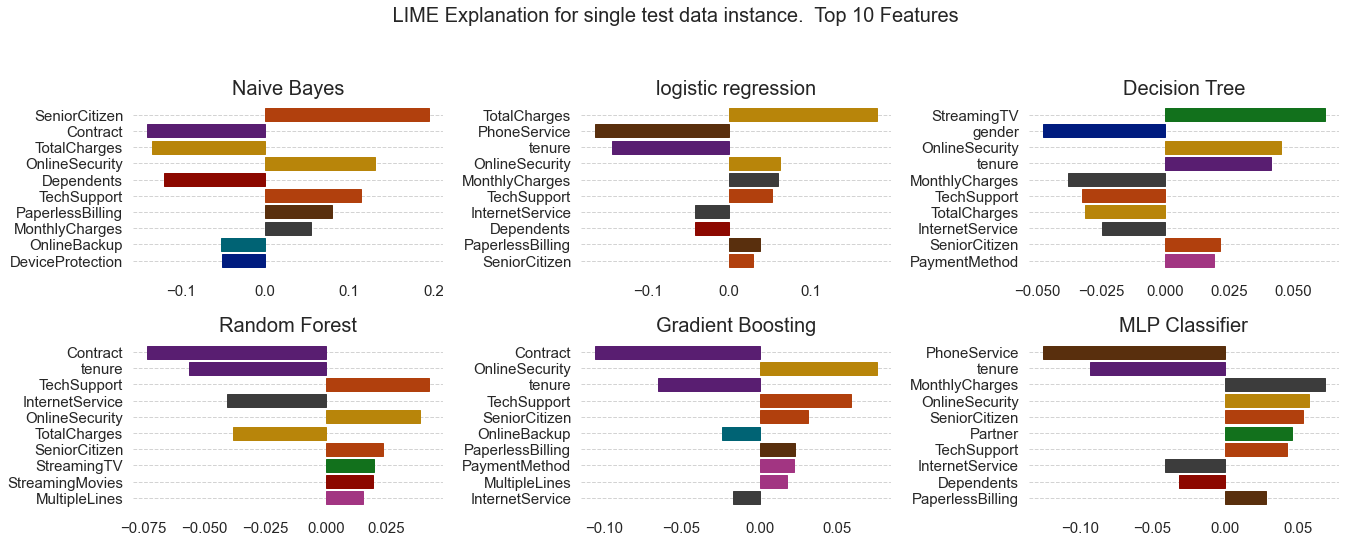

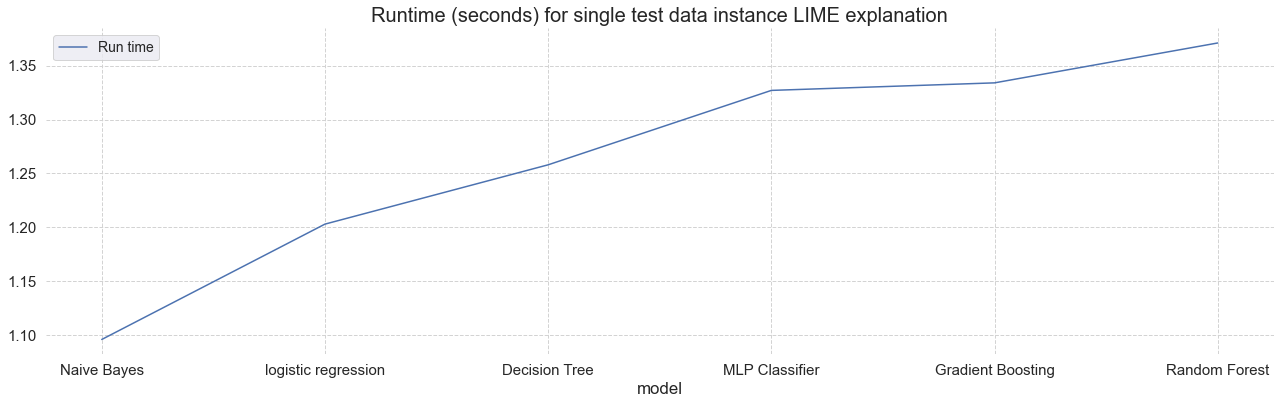

In [11]:
def plot_lime_exp(fig, fig_index, exp_data, title):
  features =  list(exp_data.keys())[::-1]
  explanations = list(exp_data.values())[::-1]
  ax = fig.add_subplot(fig_index) 
  lime_bar = ax.barh( features, explanations ) 
  ax.set_title(title, fontsize = 20)
  for i,bar in enumerate(lime_bar):
    bar.set_color(color_list[list(current_data.columns).index(features[i])])
    plt.box(False) 
fig = plt.figure(figsize=(19,8))

# Plot lime explanations for trained models
for i, dex in enumerate(lime_data_explainations):
  fig_index = 230 + i + 1 #"23" + str(i+1)
  plot_lime_exp(fig, fig_index, lime_data_explainations[i], trained_models[i]["name"])

plt.suptitle( " LIME Explanation for single test data instance.  Top " + str(top_x) + " Features", fontsize=20, fontweight="normal")
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

# Plot run time for explanations
lx_df = pd.DataFrame(lime_explanation_time)
lx_df.sort_values("time", inplace=True)
setup_plot()
lx_ax = lx_df.plot(kind="line", x="model", title="Runtime (seconds) for single test data instance LIME explanation", figsize=(22,6))
lx_ax.title.set_size(20)
lx_ax.legend(["Run time"])
plt.box(False)

### Débogage de LIME : dois-je faire confiance à l'explication ?

En dessous, l'algorithme LIME utilise un modèle linéaire approximatif pour dériver des explications locales. Comme tout autre modèle ML, ce modèle d'explication peut également avoir des problèmes. Alors, que pouvons-nous faire pour renforcer la confiance dans la qualité d'une explication. Dans un premier temps, nous pouvons vérifier si le modèle local est bien un bon approximateur du modèle original.

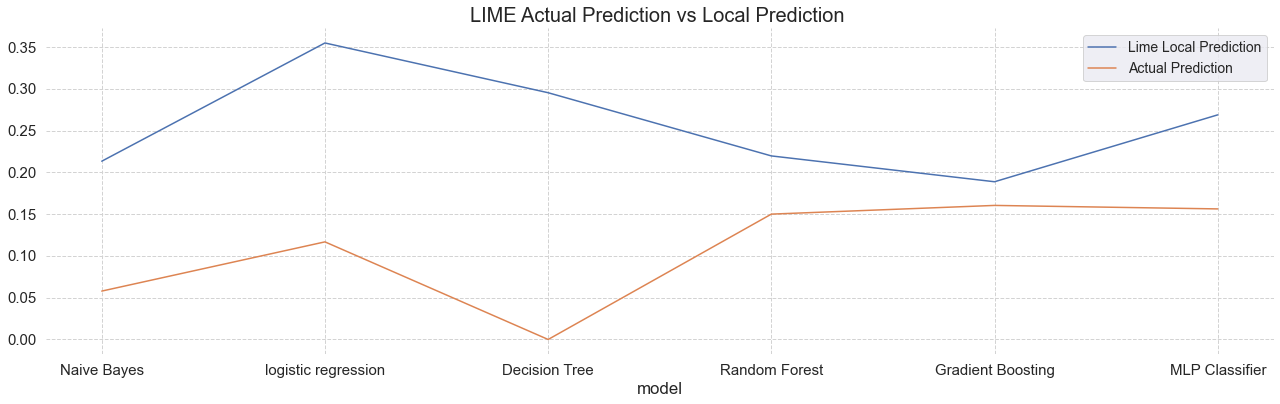

In [12]:
# Plot run time for explanations
lime_metrics_df = pd.DataFrame(lime_metrics)  
lime_metrics_df_ax = lime_metrics_df[["lime class1", "actual class1", "model"]].plot(kind="line", x="model", title="LIME Actual Prediction vs Local Prediction ", figsize=(22,6))
lime_metrics_df_ax.title.set_size(20)
lime_metrics_df_ax.legend(["Lime Local Prediction", "Actual Prediction"])
plt.box(False)

Le graphique ci-dessus montre les prédictions faites par le modèle local LIME et le modèle d'origine pour l'instance de données expliquée. Les deux nombres doivent être proches. Lorsqu'ils ne le sont pas, cela peut soulever des questions quant à savoir si nous pouvons faire confiance à l'explication. Il y a peu de choses qui peuvent être faites :

* Modifiez les paramètres de LIME pour obtenir une meilleure explication. Par exemple. augmenter le nombre de perturbations (LIME) ou la largeur du noyau (voir la discussion connexe ici),

* Améliorez notre modèle d'origine (dans ce cas, nous savons que l'arbre de décision montre des signes de surajustement).

La prochaine méthode d'explication que nous allons considérer (SHAP) vise à remédier à ces incohérences. Allons-y!

### Explications avec SHAP

Pour donner une idée du fonctionnement de SHAP, considérez le scénario suivant. Nous avons un groupe de scientifiques des données (Sarah, Jessica et Patrick) qui collaborent pour créer un excellent modèle prédictif pour leur entreprise. À la fin de l'année, leurs efforts se traduisent par une augmentation des bénéfices dont 5 millions de dollars doivent maintenant être partagés entre nos 3 héros. En supposant que nous ayons de bons moyens de mesurer (ou de simuler) les contributions de chaque scientifique des données, comment pouvons-nous répartir ce profit de manière à ce que chaque personne soit équitablement récompensée en fonction de sa contribution réelle ?

Les [valeurs de Shapley](https://en.wikipedia.org/wiki/Shapley_value) fournissent une méthode pour ce type spécifique d'allocation (paramètre de jeu multijoueur collaboratif) avec un ensemble de propriétés axiomatiques souhaitables (Efficacité, Symétrie, Linéarité, Anonymat, Marginalisme) qui garantissent l'équité. Ces valeurs sont calculées en calculant la contribution marginale moyenne de chaque personne dans tous les classements possibles. Par exemple, imaginons que nous n'affections que Sarah au projet et que nous notions l'augmentation du profit (leur contribution marginale). Nous ajoutons ensuite Jessica et notons l'augmentation correspondante. Nous ajoutons ensuite Patrick et notons leur contribution. Ceci est répété pour toutes les commandes possibles (par exemple {Patrick, Jessica, Sarah}, {Jessica, Sarah, Patrick}, etc.) et la contribution marginale moyenne pour chaque personne est calculée. En étendant cela à l'apprentissage automatique, nous pouvons considérer chaque caractéristique comme comparable à nos scientifiques des données et la prédiction du modèle comme les bénéfices. Pour expliquer notre modèle, nous ajoutons à plusieurs reprises chaque caractéristique et notons sa contribution marginale à la prédiction du modèle. Il est important de noter que nous souhaitons utiliser les valeurs de Shapley pour attribuer un crédit à chaque caractéristique, car elles fournissent deux garanties importantes (par exemple, LIME, Feature Permutation, Feature Importance) que d'autres méthodes ne fournissent pas :

* précision locale (un modèle approximatif utilisé pour expliquer le modèle d'origine doit correspondre à la sortie du modèle d'origine pour une entrée donnée)

* cohérence (si le modèle d'origine change de telle sorte qu'une caractéristique a un impact plus important dans chaque ordre possible, son attribution ne devrait pas diminuer)

En pratique, quelques simplifications sont nécessaires pour calculer les valeurs de Shapley. Le plus important est peut-être lié à la façon dont nous simulons l'ajout ou la suppression de caractéristiques lors du calcul de la prédiction du modèle. C'est difficile car il n'existe aucun moyen simple de "supprimer" une caractéristique pour la plupart des modèles prédictifs au moment du test. On peut soit remplacer la caractéristique par sa valeur moyenne, soit sa valeur médiane. Dans l'implémentation de la bibliothèque SHAP, une entité "manquante" est simulée en remplaçant l'entité par les valeurs qu'elle prend dans le jeu de données d'arrière-plan.

#### L'implémentation de la bibliothèque SHAP.

La bibliothèque SHAP contient des implémentations pour plusieurs types d'explications qui exploitent les valeurs de Shapley. Ceux-ci incluent le TreeExplainer qui est optimisé (et rapide) pour les modèles basés sur des arbres ; DeepExplainer et GradientExplainer pour les réseaux de neurones ; et KernelExplainer, qui ne fait aucune hypothèse sur le modèle sous-jacent à expliquer (modèle indépendant comme LIME).

Pour expliquer un modèle sur un jeu de test à l'aide de KernelExplainer, l'API de la bibliothèque SHAP est la suivante :

In [ ]:
import shap
explainer = shap.KernelExplainer(model.predict_proba, background_data)
shap_values = explainer.shap_values(X_test)

Pour déballer et comprendre les résultats de SHAP KernelExplainer, il y a quelques termes qui méritent d'être clarifiés.

Description des variables

* **model** le modèle à expliquer

* **background_data** Il s'agit d'un argument obligatoire pour KernelExplainer. Étant donné que la plupart des modèles ne sont pas conçus pour gérer des données manquantes arbitraires au moment du test, SHAP simule une fonctionnalité "manquante" en la remplaçant par les valeurs qu'elle prend dans l'ensemble de données d'arrière-plan. Pour les petits problèmes, cet ensemble de données d'arrière-plan peut être l'ensemble d'apprentissage, mais pour les problèmes plus importants, il est suggéré d'utiliser un sous-échantillon de l'ensemble d'apprentissage (ou la fonction kmeans pour résumer l'ensemble de données). Les données d'arrière-plan sont facultatives pour les modèles arborescents.

* **expliquer.expected_value** Il s'agit d'un champ dans l'objet explicatif affiché comme ligne de base dans un tracé de force SHAP. Il doit être identique à la moyenne de la sortie du modèle sur l'ensemble de données d'arrière-plan. Une tâche simple que j'ai trouvée utile consiste à calculer manuellement la prédiction moyenne sur l'ensemble de données d'arrière-plan et à voir comment elle correspond à la valeur attendue sortie par SHAP.

* **shap_values** ​​Les shap_values ​​renvoyées par l'objet explicateur sont une mesure de la contribution de chaque caractéristique à la différence entre la valeur attendue du modèle et la prédiction pour cette instance. Les unités des valeurs de Shapley sont dans les unités de la variable cible. La somme des valeurs de forme doit être égale à la différence entre la valeur de base et la prédiction du modèle.

### Explicateur noyau

In [13]:
current_model = trained_models[3] # Explain the Random Forest Model
clf = current_model["model"]["clf"]
scaler = current_model["model"]["scaler"]
scaled_train_data = scaler.transform(X_train)
sub_sampled_train_data = shap.sample(scaled_train_data, 600, random_state=0) # use 600 samples of train data as background data

scaled_test_data = scaler.transform(X_test) 
subsampled_test_data =scaled_test_data[test_data_index].reshape(1,-1)

start_time = time.time()
explainer = shap.KernelExplainer(clf.predict_proba, sub_sampled_train_data)
shap_values = explainer.shap_values(subsampled_test_data,  l1_reg="aic")
elapsed_time = time.time() - start_time
# explain first sample from test data
print("Kernel Explainer SHAP run time", round(elapsed_time,3) , " seconds. ", current_model["name"])
print("SHAP expected value", explainer.expected_value)
print("Model mean value", clf.predict_proba(scaled_train_data).mean(axis=0))
print("Model prediction for test data", clf.predict_proba(subsampled_test_data))
shap.initjs()
pred_ind = 0
shap.force_plot(explainer.expected_value[1], shap_values[1][0], subsampled_test_data[0], feature_names=X_train.columns)

Using 600 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

Kernel Explainer SHAP run time 16.912  seconds.  Random Forest
SHAP expected value [0.71769056 0.28230944]
Model mean value [0.73063888 0.26936112]
Model prediction for test data [[0.85 0.15]]


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

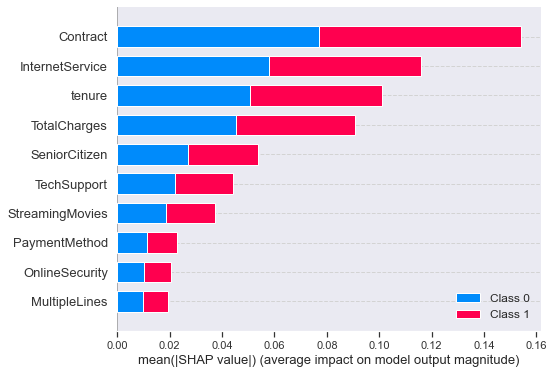

In [14]:
shap.initjs()
shap.summary_plot(shap_values, subsampled_test_data, feature_names=X_train.columns, max_display=10)

### Explicateur d'arbre

TreeExplainer sur des forêts aléatoires prend environ 0,091 seconde. Ceci est comparé à > 12,15 secondes requises par KernelExplainer (> 100x plus rapide).

In [15]:
current_model = trained_models[3]
clf = current_model["model"]["clf"]
scaler = current_model["model"]["scaler"]
 
scaled_test_data = scaler.transform(X_test) 
subsampled_test_data =scaled_test_data[test_data_index].reshape(1,-1)

# explain first sample from test data
start_time = time.time()
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(subsampled_test_data)
elapsed_time = time.time() - start_time

print("Tree Explainer SHAP run time", round(elapsed_time,3) , " seconds. ", current_model["name"])
print("SHAP expected value", explainer.expected_value)
print("Model mean value", clf.predict_proba(scaled_train_data).mean(axis=0))
print("Model prediction for test data", clf.predict_proba(subsampled_test_data))
shap.initjs()
pred_ind = 0
shap.force_plot(explainer.expected_value[1], shap_values[1][0], subsampled_test_data[0], feature_names=X_train.columns)

Tree Explainer SHAP run time 0.1  seconds.  Random Forest
SHAP expected value [0.73284793 0.26715207]
Model mean value [0.73063888 0.26936112]
Model prediction for test data [[0.85 0.15]]


### Explicateur noyau - Expliquer une instance de données de test pour tous les modèles

Dans la section suivante, nous allons générer et visualiser des explications à l'aide du SHAP KernelExplainer pour un point de données donné dans notre ensemble de test (comme nous l'avons fait pour LIME).

In [20]:
import shap
import warnings

def get_kernel_shap_explainer(model, background_data, train_data):  
  shap_explainer = shap.KernelExplainer(model.predict_proba, background_data)   
  return shap_explainer 

def shap_explain(explainer, test_data):
  with warnings.catch_warnings():
    warnings.filterwarnings("ignore")   # see : https://github.com/slundberg/shap/issues/2528
    shap_values = explainer.shap_values(test_data, l1_reg="aic")
    return shap_values

shap_data_explainations = []
shape_explanation_time = []
feat_names = list(current_data.columns) 
data_subsample = 500 
for current_model in trained_models:  
  scaler = current_model["model"]["scaler"]
  scaled_test_data = scaler.transform(X_test)
  scaled_train_data = scaler.transform(X_train)
  sampled_scaled_train_data = shap.sample(scaled_train_data, data_subsample) # subsample background data to make things faster
  
  start_time = time.time()
  shap_explainer  = get_kernel_shap_explainer(current_model["model"]["clf"], sampled_scaled_train_data, scaled_train_data)

  # explain first sample from test data 
  sampled_scaled_test_data = scaled_test_data[test_data_index].reshape(1,-1)
  shap_values = shap_explain(shap_explainer, sampled_scaled_test_data) 
  elapsed_time = time.time() - start_time 
  idx = np.argsort(np.abs(shap_values[1][0]))[::-1] 
  ex_holder = { feat_names[idx[i]] : shap_values[1][0][idx[i]] for i in range(top_x)} 
   
 
  shap_data_explainations.append(ex_holder) 
  shape_explanation_time.append({"time": elapsed_time, "model": current_model["name"] })

Using 500 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

Using 500 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

Using 500 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

Using 500 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

Using 500 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

Using 500 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

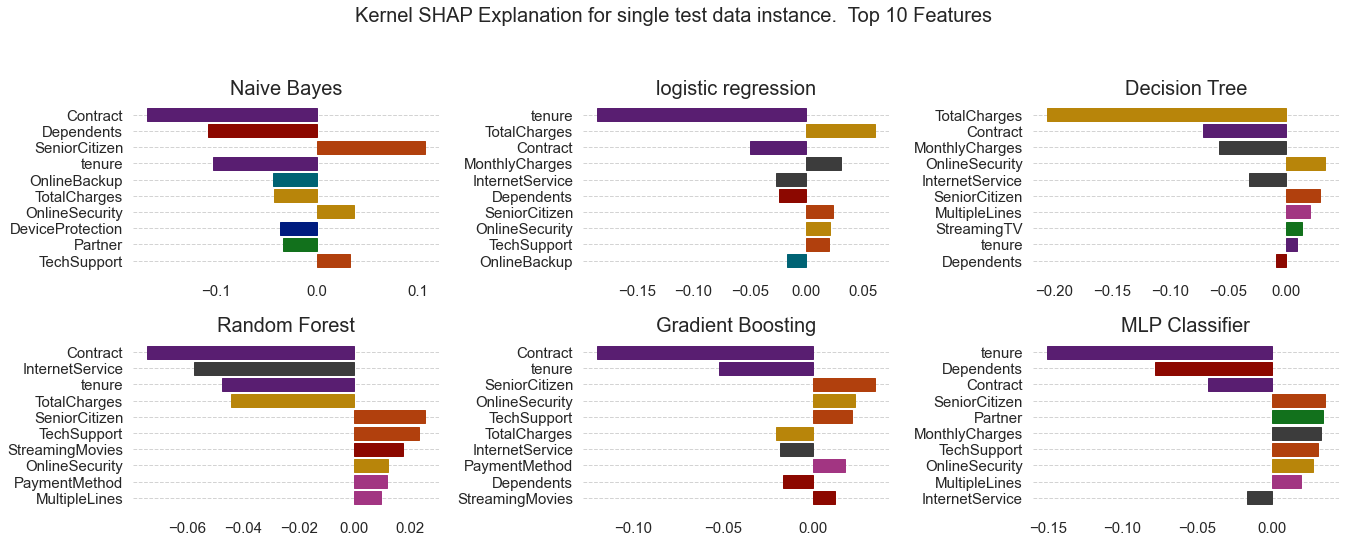

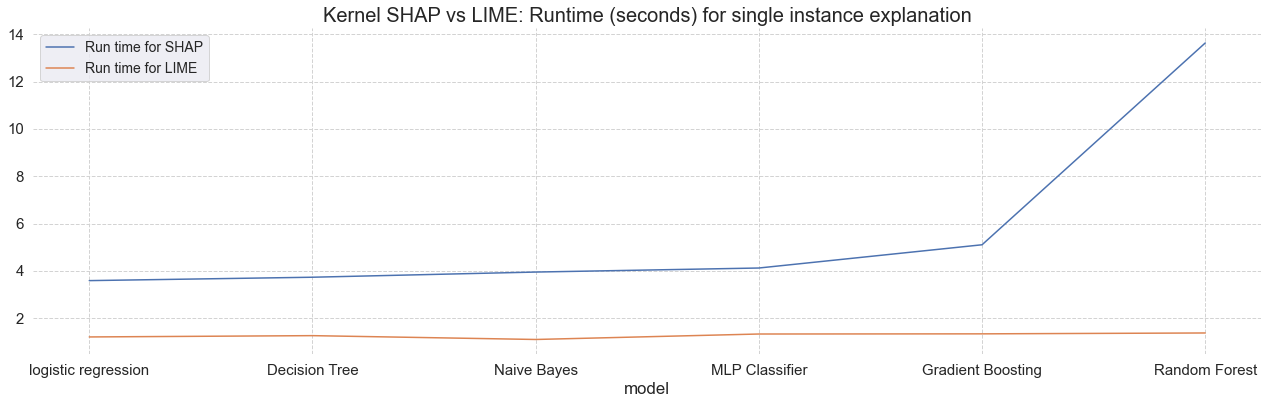

In [18]:
def plot_shap_exp(fig, fig_index, exp_data, title):
  features =  list(exp_data.keys())[::-1]
  explanations = list(exp_data.values())[::-1]
  ax = fig.add_subplot(fig_index) 
  lime_bar = ax.barh( features, explanations ) 
  ax.set_title(title, fontsize = 20)
  for i,bar in enumerate(lime_bar):
    bar.set_color(color_list[list(current_data.columns).index(features[i])])
    plt.box(False) 


# Plot SHAP explanations for a given test set item
fig = plt.figure(figsize=(19,8))
for i, dex in enumerate(shap_data_explainations):
  fig_index = 230 + i + 1 #"23" + str(i+1)
  plot_lime_exp(fig, fig_index, shap_data_explainations[i], trained_models[i]["name"])

plt.suptitle( "Kernel SHAP Explanation for single test data instance.  Top " + str(top_x) + " Features", fontsize=20, fontweight="normal")
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

# Plot SHAP explanation run time
shapx_df = pd.DataFrame(shape_explanation_time)
shapx_df.sort_values("time", inplace=True)
# setup_plot()
# shapx_df_ax = shapx_df.plot(kind="line", x="model", title="Runtime (seconds) for single instance SHAP explanation", figsize=(22,6))
# shapx_df_ax.title.set_size(20)
# shapx_df_ax.legend(["Run time"])
# plt.box(False)


# Plot both LIME and SHAP explanation run times
m_df =  shapx_df.merge(lx_df, on="model", suffixes=("_SHAP", "_LIME")) 
m_df.head() 
mx_df_ax = m_df.plot(kind="line", x="model", title="Kernel SHAP vs LIME: Runtime (seconds) for single instance explanation", figsize=(22,6))
mx_df_ax.title.set_size(20)
mx_df_ax.legend(["Run time for SHAP", "Run time for LIME"])
plt.box(False)

### Débogage de SHAP KernelExplainer : un petit ensemble de données d'arrière-plan peut entraîner une valeur attendue incohérente.

Le processus utilisé par SHAP pour simuler les valeurs manquantes s'appuie sur un ensemble de données d'arrière-plan (généralement l'ensemble d'apprentissage). Lorsque l'ensemble de données d'apprentissage est volumineux, les auteurs de SHAP suggèrent l'utilisation d'un sous-échantillon de l'ensemble d'apprentissage comme données de base pour réduire les coûts de calcul. Un effet secondaire de l'utilisation d'un petit sous-échantillon est que la valeur attendue utilisée par SHAP peut différer de la valeur moyenne du modèle. Les graphiques ci-dessous comparent la valeur attendue SHAP et la prédiction moyenne du modèle sur l'ensemble d'apprentissage pour plusieurs tailles d'échantillons d'arrière-plan.

* Le temps d'exécution augmente (linéairement) avec l'augmentation de la taille de l'ensemble de données d'arrière-plan
* La valeur attendue est plus proche de la valeur moyenne à l'entrée de la rame à mesure que la taille du sous-échantillon de fond augmente. (idéalement, ces chiffres devraient être les mêmes. Voir la discussion pertinente sur Github)

Les résultats ci-dessus soulèvent certaines questions quant à la qualité des explications lorsqu'un sous-échantillon est utilisé comme données de base pour SHAP. Il est important de noter que TreeExplainer évite ce problème car il ne nécessite pas de jeu de données d'arrière-plan. Selon la documentation SHAP.

Cet argument (données d'arrière-plan) est facultatif lorsque feature_perturbation = "tree_path_dependent", car dans ce cas, nous pouvons utiliser le nombre d'échantillons d'apprentissage qui ont parcouru chaque chemin d'arbre comme ensemble de données d'arrière-plan (ceci est enregistré dans l'objet modèle).

In [22]:
import warnings

current_model = trained_models[3]
clf = current_model["model"]["clf"]
scaler = current_model["model"]["scaler"]

sample_sizes = [50, 100, 150, 200, 300, 600, 1000, 2000, 3000, 4000]
metric_holder = []
 

for sample_size in sample_sizes:
  scaled_train_data = scaler.transform(X_train)
  sub_sampled_train_data = shap.sample(scaled_train_data, sample_size, random_state=0) # use x samples of train data as background data

  scaled_test_data = scaler.transform(X_test)
  test_data_index = 10
  subsampled_test_data =scaled_test_data[test_data_index].reshape(1,-1)

  start_time = time.time()
  explainer = shap.KernelExplainer(clf.predict_proba, sub_sampled_train_data)
  with warnings.catch_warnings():
    warnings.filterwarnings("ignore")   # see : https://github.com/slundberg/shap/issues/2528
    shap_values = explainer.shap_values(subsampled_test_data,  l1_reg="aic")
  elapsed_time = time.time() - start_time

  metric_holder.append({"class0 exp": explainer.expected_value[0], 
                        "class1 exp":explainer.expected_value[1],
                        "run time": elapsed_time,
                        "sample size": sample_size
                        })
   
metric_df = pd.DataFrame(metric_holder)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Using 150 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

Using 300 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

Using 600 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

Using 1000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

Using 2000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

Using 3000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

Using 4000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

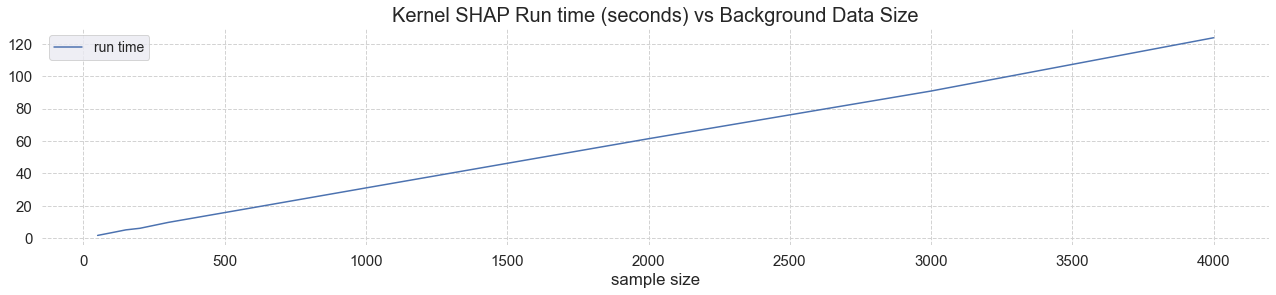

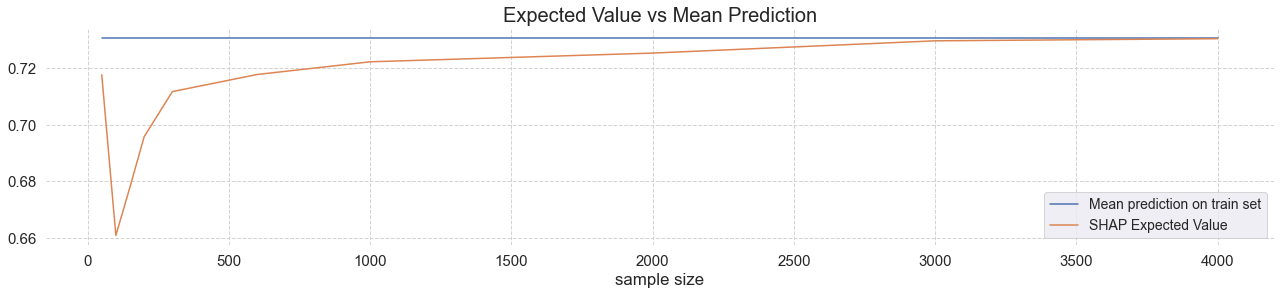

In [21]:
mean_pred = clf.predict_proba(scaled_train_data).mean(axis=0)
metric_df["mean prediction class0"] = mean_pred[0]
metric_df["mean prediction class1"] = mean_pred[1]
metric_df.head()
setup_plot()
metrix_ax = metric_df[["sample size", "run time"]].plot(kind="line", x="sample size", title="Kernel SHAP Run time (seconds) vs Background Data Size", figsize=(22,4))
metrix_ax.title.set_size(20) 
plt.box(False)

setup_plot()
metrix_ax = metric_df[["sample size", "mean prediction class0", "class0 exp"]].plot(kind="line", x="sample size", title="Expected Value vs Mean Prediction", figsize=(22,4))
metrix_ax.title.set_size(20) 
metrix_ax.legend(["Mean prediction on train set", "SHAP Expected Value"])
plt.box(False)

### LIME vs SHAP : Quand utiliser quoi ?

LIME et SHAP sont de bonnes méthodes pour expliquer les modèles. En théorie, SHAP est la meilleure approche car elle fournit des garanties mathématiques pour l'exactitude et la cohérence des explications. En pratique, l'implémentation indépendante du modèle de SHAP (KernelExplainer) est lente, même avec des approximations. Ce problème de vitesse est beaucoup moins préoccupant si vous utilisez un modèle basé sur un arbre et que vous pouvez tirer parti des optimisations mises en œuvre dans SHAP TreeExplainer (nous avons vu qu'il pouvait être jusqu'à 100 fois plus rapide que KernelExplainer).

Certaines limitations supplémentaires des deux méthodes sont mentionnées ci-dessous

* LIME n'est pas conçu pour fonctionner avec des données encodées à chaud. Considérant que chaque point de données est perturbé pour créer le modèle approximatif, la perturbation d'une variable encodée à chaud peut entraîner des caractéristiques inattendues (sans signification). Voir [débat ici](https://github.com/marcotcr/lime/issues/153)

* LIME dépend de la capacité à perturber les échantillons de manière significative. Cette perturbation est spécifique au cas d'utilisation. Par exemple, pour les données tabulaires, cela implique l'ajout de bruit aléatoire à chaque caractéristique ; pour les images, cela implique de remplacer les superpixels dans l'image par une valeur moyenne ou des zéros ; pour le texte, cela implique de supprimer des mots du texte. Il est souvent utile de réfléchir aux effets secondaires de ces stratégies de perturbation par rapport à vos données pour renforcer la confiance dans l'explication.

* Dans certains cas, le modèle local construit par LIME peut ne pas se rapprocher du comportement du modèle d'origine. Il est recommandé de vérifier ces incohérences avant de faire confiance aux explications de LIME.

* LIME fonctionne avec des modèles qui génèrent des probabilités pour les problèmes de classification. Les modèles comme les SVM ne sont pas particulièrement conçus pour générer des probabilités (bien qu'ils puissent y être contraints avec certains [problèmes](https://scikit-learn.org/stable/modules/svm.html)). Cela peut introduire un certain biais dans les explications.

* SHAP dépend des ensembles de données d'arrière-plan pour déduire une valeur de référence/attendue. Pour les grands ensembles de données, il est coûteux en calcul d'utiliser l'intégralité de l'ensemble de données et nous devons nous fier à des approximations (par exemple, sous-échantillonner les données). Cela a des conséquences sur la précision de l'explication.

* SHAP explique l'écart d'une prédiction par rapport à la valeur attendue/de référence qui est estimée à l'aide de l'ensemble de données d'apprentissage. Selon le cas d'utilisation spécifique, il peut être plus significatif de calculer la valeur attendue à l'aide d'un sous-ensemble spécifique de l'ensemble d'apprentissage plutôt que de l'ensemble d'apprentissage complet. Par exemple, il peut être plus significatif d'expliquer une prédiction d'attrition par rapport à la manière dont elle s'écarte des clients qui n'ont pas d'attrition. Ici, nous pourrions vouloir utiliser l'ensemble de données des clients qui n'ont pas résilié comme ensemble de données d'arrière-plan. Voir ce problème ici.

### Conclusion et lectures complémentaires

Dans ce cahier, nous avons examiné LIME et SHAP. En fait, nous n'avons examiné que des sous-ensembles de ces deux outils remarquables, en nous concentrant sur l'explication des modèles construits sur des données tabulaires. Il convient de noter que ces méthodes peuvent être étendues pour travailler également sur du texte et des données d'image. Pour une lecture supplémentaire sur d'autres méthodes d'interprétabilité, le livre [Interpretable ML de Christoph Molnar est recommandé](https://christophm.github.io/interpretable-ml-book/).

* Interprétabilité - Cloudera Fast Forward Labs https://ff06-2020.fastforwardlabs.com/
* SHAP vs gradients intégrés https://blog.fiddler.ai/2019/08/should-you-explain-your-predictions-with-shap-or-ig/
* Apprentissage automatique interprétable https://christophm.github.io/interpretable-ml-book/

# Scikit-learn User Guide | 4. Inspection